In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LinearRegression

In [55]:
indicator=["^VIX","SPY"]
start_date="2019-01-01"
end_date="2024-09-01"
data=yf.download(indicator, start=start_date, end=end_date,actions=True)
#print(data)

[*********************100%%**********************]  2 of 2 completed


In [56]:
data=data.reset_index()
data['t']=range(1,len(data)+1)
#print(data)

In [57]:
def subscript(num):
    subscript_nums=str.maketrans('0123456789','₀₁₂₃₄₅₆₇₈₉')
    return str(num).translate(subscript_nums)

data['VIX_sub']=data['t'].apply(lambda x: f"VIX{subscript(x)}")
data['Dividends_sub']=data['t'].apply(lambda x: f"Dividends{subscript(x)}")
data['SPY_sub']=data['t'].apply(lambda x:f"SPY{subscript(x)}")
#print(data)

In [58]:
subscript_data=pd.DataFrame({
    'Date':data['Date'].tolist(),
    'VIX_sub':data['VIX_sub'].tolist(),
    'VIX_value':data['Close']['^VIX'].tolist(),
    'Dividends_sub':data['Dividends_sub'].tolist(),
    'Dividends_value':data['Dividends']['SPY'].tolist(),
    'SPY_sub':data['SPY_sub'].tolist(),
    'SPY_value':data['Close']['SPY'].tolist()
})
#print(subscript_data)

In [59]:
subscript_data['Date']=pd.to_datetime(subscript_data['Date'])
subscript_data=subscript_data.sort_values(by='Date').reset_index(drop=True)

subscript_data['Return']=(subscript_data['SPY_value']+subscript_data['Dividends_value'])/\
subscript_data['SPY_value'].shift(1)-1

#print(subscript_data)

In [60]:
subscript_data['Year&Month']=subscript_data['Date'].dt.to_period('M')
monthly_std=subscript_data.groupby('Year&Month')['Return'].std().reset_index()
monthly_std.columns=['Year&Month','Return_Std']
#print(monthly_std)
subscript_data=subscript_data.merge(monthly_std, on='Year&Month', how='left')
print(subscript_data)

           Date  VIX_sub  VIX_value  Dividends_sub  Dividends_value  SPY_sub  \
0    2019-01-02     VIX₁  23.219999     Dividends₁              0.0     SPY₁   
1    2019-01-03     VIX₂  25.450001     Dividends₂              0.0     SPY₂   
2    2019-01-04     VIX₃  21.379999     Dividends₃              0.0     SPY₃   
3    2019-01-07     VIX₄  21.400000     Dividends₄              0.0     SPY₄   
4    2019-01-08     VIX₅  20.469999     Dividends₅              0.0     SPY₅   
...         ...      ...        ...            ...              ...      ...   
1421 2024-08-26  VIX₁₄₂₂  16.150000  Dividends₁₄₂₂              0.0  SPY₁₄₂₂   
1422 2024-08-27  VIX₁₄₂₃  15.430000  Dividends₁₄₂₃              0.0  SPY₁₄₂₃   
1423 2024-08-28  VIX₁₄₂₄  17.110001  Dividends₁₄₂₄              0.0  SPY₁₄₂₄   
1424 2024-08-29  VIX₁₄₂₅  15.650000  Dividends₁₄₂₅              0.0  SPY₁₄₂₅   
1425 2024-08-30  VIX₁₄₂₆  15.000000  Dividends₁₄₂₆              0.0  SPY₁₄₂₆   

       SPY_value    Return Year&Month  

In [61]:
VIX_month=subscript_data.groupby('Year&Month')['VIX_value'].last().reset_index()
VIX_month.columns=['Year&Month','VIX_month']
subscript_data=subscript_data.merge(VIX_month, on='Year&Month', how='left')
#print(subscript_data)

In [85]:
subscript_data=subscript_data.sort_values(by='Date').reset_index(drop=True)

month_data=subscript_data.groupby('Year&Month').first().reset_index()

month_data['Return_Std_NextMonth']=month_data['Return_Std'].shift(-1)


#print(month_data)
month_data=month_data.dropna(subset=['Return_Std_NextMonth','VIX_month'])
print(month_data)

   Year&Month       Date  VIX_sub  VIX_value  Dividends_sub  Dividends_value  \
0     2019-01 2019-01-02     VIX₁  23.219999     Dividends₁              0.0   
1     2019-02 2019-02-01    VIX₂₂  16.139999    Dividends₂₂              0.0   
2     2019-03 2019-03-01    VIX₄₁  13.570000    Dividends₄₁              0.0   
3     2019-04 2019-04-01    VIX₆₂  13.400000    Dividends₆₂              0.0   
4     2019-05 2019-05-01    VIX₈₃  14.800000    Dividends₈₃              0.0   
..        ...        ...      ...        ...            ...              ...   
62    2024-03 2024-03-01  VIX₁₃₀₀  13.110000  Dividends₁₃₀₀              0.0   
63    2024-04 2024-04-01  VIX₁₃₂₀  13.650000  Dividends₁₃₂₀              0.0   
64    2024-05 2024-05-01  VIX₁₃₄₂  15.390000  Dividends₁₃₄₂              0.0   
65    2024-06 2024-06-03  VIX₁₃₆₄  13.110000  Dividends₁₃₆₄              0.0   
66    2024-07 2024-07-01  VIX₁₃₈₃  12.220000  Dividends₁₃₈₃              0.0   

    SPY_sub   SPY_value    Return  Retu

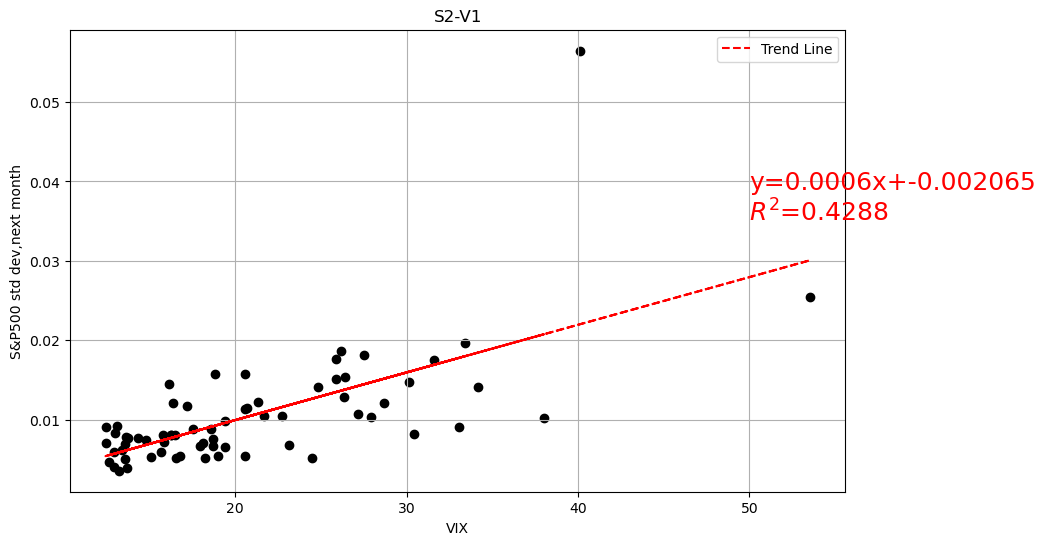

In [84]:
x=month_data['VIX_month'].values.reshape(-1,1)
y=month_data['Return_Std_NextMonth'].values

plt.figure(figsize=(10,6))
plt.scatter(month_data['VIX_month'],month_data['Return_Std_NextMonth'],color='black')

model=LinearRegression()
model.fit(x,y)
y_pred=model.predict(x)

slope=model.coef_[0]
intercept=model.intercept_
r_square=model.score(x,y)

plt.plot(x,y_pred,color='red',linestyle='--',label='Trend Line')

equation_text=f"y={slope:.4f}x+{intercept:4f}\n$R^2$={r_square:.4f}"
plt.text(50,0.035,equation_text,fontsize=18,color='red')

plt.title('S2-V1')
plt.xlabel('VIX')
plt.ylabel('S&P500 std dev,next month')

plt.grid()
plt.legend()
plt.show()

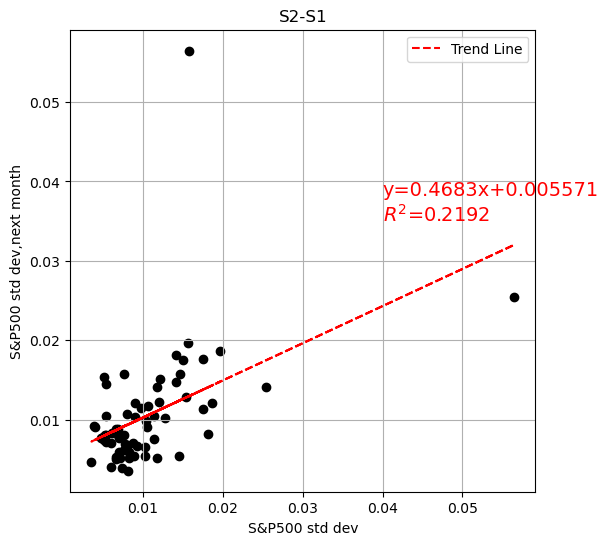

In [81]:
x=month_data['Return_Std'].values.reshape(-1,1)
y=month_data['Return_Std_NextMonth'].values

plt.figure(figsize=(6,6))
plt.scatter(month_data['Return_Std'],month_data['Return_Std_NextMonth'],color='black')

model=LinearRegression()
model.fit(x,y)
y_pred=model.predict(x)

slope=model.coef_[0]
intercept=model.intercept_
r_square=model.score(x,y)

plt.plot(x,y_pred,color='red',linestyle='--',label='Trend Line')

equation_text=f"y={slope:.4f}x+{intercept:4f}\n$R^2$={r_square:.4f}"
plt.text(0.04,0.035,equation_text,fontsize=14,color='red')

plt.title('S2-S1')
plt.xlabel('S&P500 std dev')
plt.ylabel('S&P500 std dev,next month')

plt.grid()
plt.legend()
plt.show()

In [83]:
VIX_month=month_data['VIX_month']
Return_Std=month_data['Return_Std']
Return_Std_NextMonth=month_data['Return_Std_NextMonth']

Corr_V_S2=VIX_month.corr(Return_Std_NextMonth)
Corr_S1_S2=Return_Std.corr(Return_Std_NextMonth)
r1=Corr_V_S2
r2=Corr_S1_S2
print(r1,r2)

0.6547920824103411 0.46822123974172886


In [86]:
print(month_data.isna().sum())

Year&Month              0
Date                    0
VIX_sub                 0
VIX_value               0
Dividends_sub           0
Dividends_value         0
SPY_sub                 0
SPY_value               0
Return                  0
Return_Std              0
VIX_month               0
Return_Std_NextMonth    0
dtype: int64


In [91]:
n1=67
n2=67
def fisher_z_transform(r):
    return 0.5*np.log(1+r)/(1-r)

z1=fisher_z_transform(r1)
z2=fisher_z_transform(r2)

z=(z1-z2)/np.sqrt(1/(n1-3)+1/(n2-3))

level_95=1.96
level_99=2.576

print(f'z1:{z1:.4f}\tz2:{z2:.4f}\tz:{z:.4f}')
if abs(z)>level_95:
    print('significantly different at 95% level')
else:
    print('no significant difference at 95% level')
    
if abs(z)>level_99:
    print('significantly different at 99% level')
else:
    print('no significant difference at 99% level')

z1:0.7295	z2:0.3611	z:2.0841
significantly different at 95% level
no significant difference at 99% level
